#### Week 1: Vector Search Applications w/ LLMs.  Authored by Chris Sanchez.

# Project 1.2

# Overview

Welcome to Week 1: Part 2 of this course!  In our first notebook we handled the data preprocessing steps which included:
- Chunking/splitting
- Vectorization of text
- Combining with metadata
- Saving to disk

We'll move on now to working with **Weaviate** to perform the following operations:
- Data Indexing
- Keyword search
- Vector search
- Hybrid search
- Retrieval Evaluation

![weaviate]( 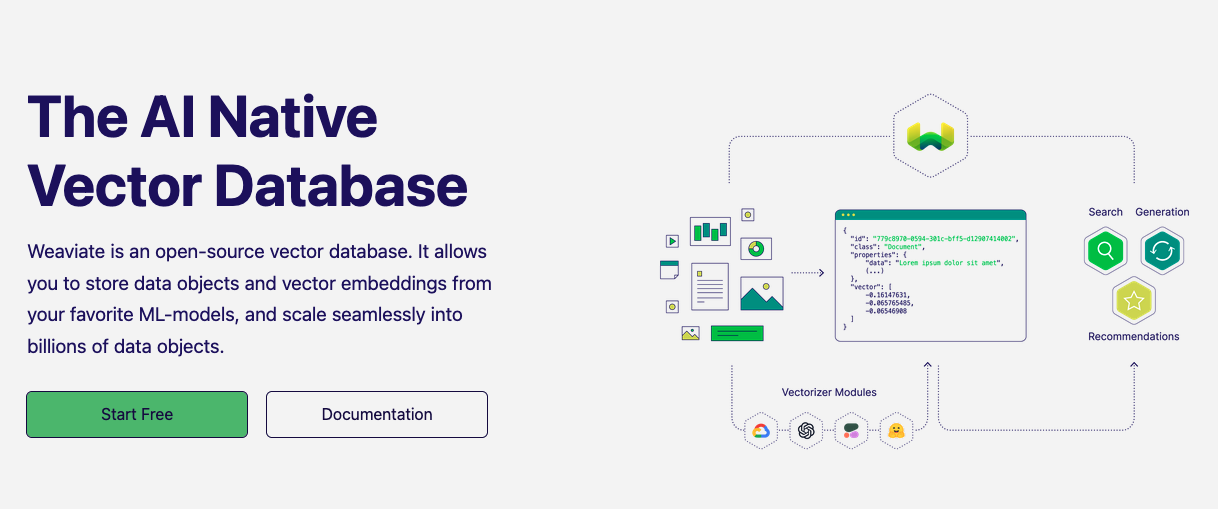)

# Approach
As a reminder, we will divide the approach to building this system into four parts over two weeks-

#### Week One
* ~Part 1:~
  * ~Data ingest and preprocessing~
  * ~Convert text into vectors~
* Part 2 (**THIS NOTEBOOK**):
  * Index data on Weaviate database
  * Benchmark retrieval results  

#### Week Two
* Part 3:
  * Add a reranker to the mix (new benchmark)
  * Integrate with ChatGPT-Turbo
* Part 4:
  * Benchmark overall system
  * Display results in Streamlit


#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

![arch_diagram]( 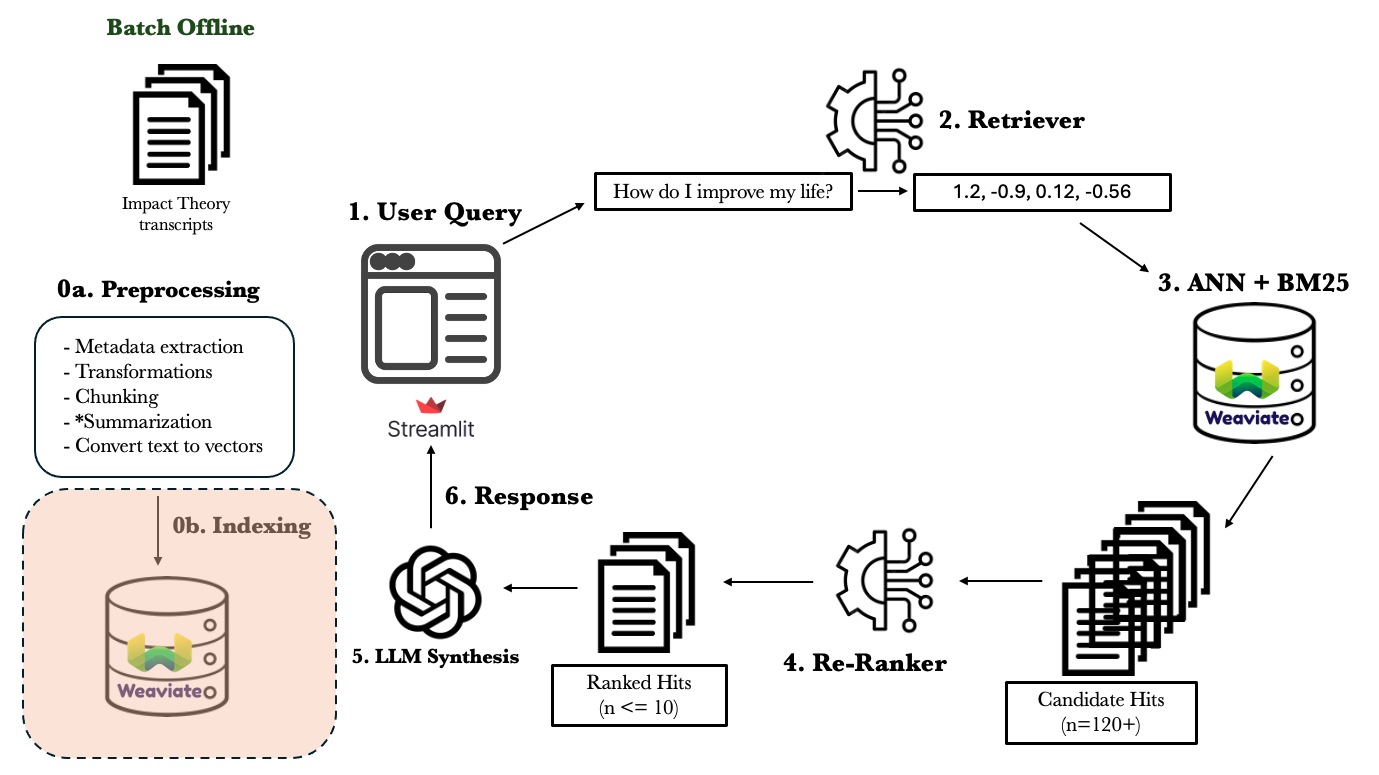)

## Download preprocessing file (helper code) from public repo

In [16]:
# uncomment line below if running this notebook on Google Colab
# !curl -o preprocessing.py https://raw.githubusercontent.com/americanthinker/vector_search_applications_PUBLIC/master/preprocessing.py

In [48]:
%load_ext autoreload 
%autoreload 2
    
from preprocessing import FileIO
from class_templates import impact_theory_class_properties
from weaviate_interface import WeaviateClient
import os
import time
from rich import print  # nice library that provides improved printing output (overrides default print function)
import json
import weaviate
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

<div class="alert alert-danger"><h3>This Notebook assumes that you have already created an account with Weaviate and have created a Weaviate instance on Weaviate Cloud Services (WCS)</h3></div>

### Instantiate Weaviate Client

The pre-written WeaviateClient Class is a convenient wrapper around the Weaviate python API.  We'll use it to create a Weaviate client to connect with our Weaviate Cloud instance.  
Instantiating the Class requires 3 main pieces of information that will change from user to user:
- a model name or path for use with vector searches
- the Weaviate instance endpoint 
- your personal Weaviate api key

In a production setting you'd have to account for security layers, but for this course we'll be working with a dev instance. 

In [14]:
#read env vars from local .env file
api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']

#instantiate client
client = WeaviateClient(api_key, url)

#check if WCS instance is live and ready
client.is_live(), client.is_ready()

(True, True)

### Display Existing Classes

In [15]:
client.show_classes()

['Question', 'ImpactTheory']

### Load saved dataset from disk

In [41]:
data_path = './practice_data/impact_theory_minilm_256.parquet'

In [42]:
data = FileIO().load_parquet(data_path)

Shape of data: (26648, 16)
Memory Usage: 3.08+ MB


To ensure confidence in our data processing skills we can confirm that all the embeddings are the same length.  For the `all-minilm-L6-v2` model the length should be 384. 

In [33]:
embedding_dim = 384
for d in data:
    assert len(d['content_embedding']) == embedding_dim

In [43]:
#let's go ahead and remove some unwanted fields
unwanted_fields = ['keywords', 'age_restricted', 'description']
for field in unwanted_fields:
    for d in data:
        del d[field]

In [47]:
# data[0]

### Data Indexing

Similar to the way we saved our dataset, we want to enforce a standard class/index naming convention from the very outset.  
- name of Podcast
- model name
- chunk size

Example:
```
impact-theory-minilm-256
```

In [34]:
class_name = 'impact-theory-minilm-256'

#### Define Class schema

The filterable index is only capable of filtering, while the searchable index can be used for both searching and filtering (though not as fast as the filterable index).
So, setting "indexFilterable": false and "indexSearchable": true (or not setting it at all) will have the trade-off of worse filtering performance but faster imports (due to only needing to update one index) and lower disk usage.
A rule of thumb to follow when determining whether to switch off indexing is: if you will never perform queries based on this property, you can turn it off.

In [55]:
#go ahead and take a look at the predefined schema for the impact-theory-minilm-256 class
print(impact_theory_class_properties)

[
    {'name': 'author', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'title', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': True},
    {'name': 'video_id', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': True},
    {'name': 'length', 'dataType': ['number'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'publish_date', 'dataType': ['date'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'thumbnail_url', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': False},
    {'name': 'views', 'dataType': ['number'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'episode_url', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': False},
    {'name': 'doc_id', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': False},
    {'name': 'content', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': True}
]

In [53]:
#Review Indexing Body
class_mapping = {
  "class": "ImpactTheory",                                        # The name of the collection in string format
  "description": "Episodes of Impact Theory up to Nov 2023",       # A description for your reference
  "vectorIndexType": "hnsw",                                      # ANN algorithm, not that you have choice with weaviate :)
  "vectorIndexConfig": {
    ...                                     # Vector index type specific settings, including distance metric
  },
  "vectorizer": "none",                     # Vectorizer to use for data objects added to this class                                       
                                            # we are providing the vectors ourselves through our SentenceTransformer model, so this field is none
  "properties": impact_theory_class_properties }          # defined schema for this class






#       "moduleConfig": {                     # Module-specific settings
#         "text2vec-contextionary": {
#           "skip": "true",                     # If "true", the whole property will NOT be included in
#                                             #    vectorization. Default is false, meaning that the
#                                             #    object will be NOT be skipped.
#           "vectorizePropertyName": "true",    # Whether the name of the property is used in the
#                                             #    calculation for the vector position of data
#                                             #    objects. Default false.
#         }
#       },
#       "indexFilterable": "true",              # Optional, default is true. By default each property
#                                             #    is indexed with a roaring bitmap index where
#                                             #     available for efficient filtering.
#       "indexSearchable": "true",               # Optional, default is true. By default each property
#                                             #    is indexed with a searchable index for
#                                             #    BM25-suitable Map index for BM25 or hybrid
#                                             #    searching
#   "invertedIndexConfig": {                  # Optional, index configuration
#     "stopwords": {
#       ...                                   # Optional, controls which words should be ignored in the inverted index, see section below
#     },
#     "indexTimestamps": "false",               # Optional, maintains inverted indices for each object by its internal timestamps
#     "indexNullState": "false",                # Optional, maintains inverted indices for each property regarding its null state
#     "indexPropertyLength": "false"            # Optional, maintains inverted indices for each property by its length
#   },
#   "shardingConfig": {
#     ...                                     # Optional, controls behavior of the collection in a
#                                             #    multi-node setting, see section below
#   },
#   "multiTenancyConfig": {"enabled": "true"}   # Optional, for enabling multi-tenancy for this
#                                             #    collection (default: "false")
# }

In [56]:
print(class_mapping)

{
    'class': 'ImpactTheory',
    'description': 'Episodes of Impact Theory up to Nov 2023',
    'vectorIndexType': 'hnsw',
    'vectorIndexConfig': {Ellipsis},
    'vectorizer': 'none',
    'properties': [
        {'name': 'author', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': False},
        {'name': 'title', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': True},
        {'name': 'video_id', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': True},
        {'name': 'length', 'dataType': ['number'], 'indexFilterable': True, 'indexSearchable': False},
        {'name': 'publish_date', 'dataType': ['date'], 'indexFilterable': True, 'indexSearchable': False},
        {'name': 'thumbnail_url', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': False},
        {'name': 'views', 'dataType': ['number'], 'indexFilterable': True, 'indexSearchable': False},
        {'name': 'episode_url', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': False},
        {'name': 'doc_id', 'dataType': ['text'], 'indexFilterable': True, 'indexSearchable': False},
        {'name': 'content', 'dataType': ['text'], 'indexFilterable': False, 'indexSearchable': True}
    ]
}

In [12]:
%%time
osclient.document_indexer(index_name=index_name, data=data, chunk_size=5, body_template=youtube_body, semantic_index=True)
time.sleep(30)

2023-11-02 21:24:05.235 | INFO     | opensearch_interface:document_indexer:212 - The ** impact-theory-minilm-196 ** index was created
2023-11-02 21:24:05.237 | INFO     | opensearch_interface:document_indexer:219 - The # of documents to be indexed = 37007
100%|███████████████████████████████████████████████████████████████████████| 37007/37007 [02:41<00:00, 229.18Docs Indexed/s]


CPU times: user 17.6 s, sys: 1.44 s, total: 19.1 s
Wall time: 3min 12s


In [62]:
osclient.indices.refresh(index_name)

{'_shards': {'total': 6, 'successful': 3, 'failed': 0}}

In [57]:
osclient.indices.delete(index_name)

{'acknowledged': True}

## Test Search on New Index

In [14]:
query = "Like why the new company, Cellularity, why are you doing that? It's gonna take an incredible amount of time, energy, and effort."

### Keyword Search

In [17]:
kw_response = osclient.keyword_search(query=query, index=index_name, size=5)
print(kw_response)

[
    {
        '_index': 'impact-theory-minilm-196',
        '_id': '6x_tkYsB1OxrodOh9b8k',
        '_score': 47.884064,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=mJNM7iLAibU&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 2247,
            'episode_num': 61,
            'title': 'A Future Without Death | Bob Hariri on Impact Theory',
            'thumbnail_url': 'https://i.ytimg.com/vi/mJNM7iLAibU/hq720.jpg',
            'doc_id': 'mJNM7iLAibU_4',
            'publish_date': '02-27-2018',
            'content': "It's true. Which is pretty crazy, so I'm really amped up to get you on and give you a 
chance to talk about some of the things that I know you've got going on in your life. And I think the most fun 
place to start with you is you've been absurdly successful by every worldly measure, but you're still super driven.
What drives you? Like why the new company, Cellularity, why are you doing that? It's gonna take an incredible 
amount of time, energy, and effort. So what is the goal with the company and why are you so driven to make it 
happen? Well, you know, I think it goes back to one of our early conversations. When I remember flying into the 
little tiny airport near your offices outside of L.A., and I picked you up, remember? Yes.",
            'views': 30633,
            'video_id': 'mJNM7iLAibU'
        }
    },
    {
        '_index': 'impact-theory-minilm-196',
        '_id': '7B_tkYsB1OxrodOh9b8k',
        '_score': 25.552937,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=mJNM7iLAibU&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 2247,
            'episode_num': 61,
            'title': 'A Future Without Death | Bob Hariri on Impact Theory',
            'thumbnail_url': 'https://i.ytimg.com/vi/mJNM7iLAibU/hq720.jpg',
            'doc_id': 'mJNM7iLAibU_5',
            'publish_date': '02-27-2018',
            'content': "Yes. And we started talking about where we thought cellular medicine and stem cells were 
gonna go to change the lives of people that we care about. And we talked about the fact that a new revolution in 
medicine was upon us. And we got very far along, but we haven't completed the journey yet. And so part of the 
driving force behind Cellularity and my efforts to lead us into this next evolution is to bring all of these 
therapeutic products to the mainstream. Just like the remarkable things you've done in nutrition would not have 
been possible if it was unapproachable economically, right? So that was part of this whole mission. So Cellularity 
is a product of 20 years of effort to turn living cells into medicines, identify the best places where they work, 
and then deliver them in a scalable economical way so that everybody has access. But why do you give a shit? It's 
gonna be so much work.",
            'views': 30633,
            'video_id': 'mJNM7iLAibU'
        }
    },
    {
        '_index': 'impact-theory-minilm-196',
        '_id': '2R_skYsB1OxrodOh0IMB',
        '_score': 22.049007,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=iWtRUN0SQhI&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 9333,
            'episode_num': 293,
            'title': 'How To Create A MORNING ROUTINE To Achieve Your MOST AMBITIOUS GOALS In 2023 | Tom Bilyeu',
            'thumbnail_url': 'https://i.ytimg.com/vi/iWtRUN0SQhI/hq720.jpg',
            'doc_id': 'iWtRUN0SQhI_111',
            'publish_date': '11-24-2022',
            'content': "Right? Man, it was incredible. It was so beautiful. The look on their face at that moment 
where they see themselves for the first time in front of the mirror and they are seeing something totally new. 
They're seeing a version of themselves that they did not know was there. And the ability to give that gift, like it
is so easy to get lost in the day-to-day grind of what you do, what any of us do. But if at the core o

### Vector Search

In [19]:
vec_response = osclient.vector_search(query, index_name, size=5)
print(vec_response)

[
    {
        '_index': 'impact-theory-minilm-196',
        '_id': '8B_skYsB1OxrodOh2IZA',
        '_score': 0.56157386,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=OAXi4jcCrWA&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 6451,
            'episode_num': 277,
            'title': '“The First Hour Of The Morning Is CRUCIAL” - Millionaire Habits For SUCCESS! | Bedros 
Keuilian',
            'thumbnail_url': 'https://i.ytimg.com/vi/OAXi4jcCrWA/hq720.jpg',
            'doc_id': 'OAXi4jcCrWA_5',
            'publish_date': '10-04-2022',
            'content': "but If you are inefficient to your point about okay, we all have the same number of hours 
So it comes down to how are you spending your time? But there's something like I find myself wanting to say more 
words because there's something ineffable that I'm not capturing yet which is there is a really subtle difference 
between a high-performance day and Mediocre day and when I think about certainly the thing that has been my 
superpower is I'm able to generate momentum So I can go from standing still nobody knows who I am nobody believes 
in what I'm trying to do We don't have a company incorporated like all of that and then oh, you know Those firms 
like getting the machine moving is so hard That's what I can do and whether that's a new project whether that's a 
whole company, whatever.",
            'views': 259625,
            'video_id': 'OAXi4jcCrWA'
        }
    },
    {
        '_index': 'impact-theory-minilm-196',
        '_id': '_h_ukYsB1OxrodOhN8vY',
        '_score': 0.5471567,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=aIVCyp_7Cqc&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 2998,
            'episode_num': 19,
            'title': 'Billionaire REVEALS The Key Habits That Will CHANGE Your Life! | John Paul Dejoria',
            'thumbnail_url': 'https://i.ytimg.com/vi/aIVCyp_7Cqc/hq720.jpg',
            'doc_id': 'aIVCyp_7Cqc_64',
            'publish_date': '05-02-2017',
            'content': "The best way to explain it is by actually doing something. Let's take a huge business 
throughout the world, one of the biggest, telecommunications. You have giant phone companies, you have servers that
on your cellular phone, it's almost like a lifestyle now, right? Well, how does someone get in that industry and 
all of a sudden you got all the giants you're going up against that have multi millions and billions of dollars, 
how do you do it? Well, you look at what the industry is lacking and pull the industry into it. Give you an 
example, it's one of my latest companies, ROK, R-O-K Mobile. ROK Mobile, believe it or not, we found the openings, 
I'll tell you how we did it.",
            'views': 1318528,
            'video_id': 'aIVCyp_7Cqc'
        }
    },
    {
        '_index': 'impact-theory-minilm-196',
        '_id': 'Ax_tkYsB1OxrodOh9cB1',
        '_score': 0.5351826,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=mJNM7iLAibU&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 2247,
            'episode_num': 61,
            'title': 'A Future Without Death | Bob Hariri on Impact Theory',
            'thumbnail_url': 'https://i.ytimg.com/vi/mJNM7iLAibU/hq720.jpg',
            'doc_id': 'mJNM7iLAibU_28',
            'publish_date': '02-27-2018',
            'content': "Not a lot of sycophants who just wanna sort of make you happy. And also, you know what? You
need to bring in new blood with completely opposing points of view. So we've tried to do that at Cellularity. And I
think it's very helpful. But at the same time, I want people to fully exploit the power of this connectivity to our
original parent company, to the companies we're strategically partnered with, to allied companies that are equity 
holders in Cellularity, but also business partners. And by doing that, I think we avoid lots of the problem

### Hybrid Search

In [20]:
hyb_response = osclient.hybrid_search(query, index_name, index_name, kw_size=3, vec_size=3)
print(hyb_response)

[
    {
        '_index': 'impact-theory-minilm-196',
        '_id': '6x_tkYsB1OxrodOh9b8k',
        '_score': 47.884064,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=mJNM7iLAibU&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 2247,
            'episode_num': 61,
            'title': 'A Future Without Death | Bob Hariri on Impact Theory',
            'thumbnail_url': 'https://i.ytimg.com/vi/mJNM7iLAibU/hq720.jpg',
            'doc_id': 'mJNM7iLAibU_4',
            'publish_date': '02-27-2018',
            'content': "It's true. Which is pretty crazy, so I'm really amped up to get you on and give you a 
chance to talk about some of the things that I know you've got going on in your life. And I think the most fun 
place to start with you is you've been absurdly successful by every worldly measure, but you're still super driven.
What drives you? Like why the new company, Cellularity, why are you doing that? It's gonna take an incredible 
amount of time, energy, and effort. So what is the goal with the company and why are you so driven to make it 
happen? Well, you know, I think it goes back to one of our early conversations. When I remember flying into the 
little tiny airport near your offices outside of L.A., and I picked you up, remember? Yes.",
            'views': 30633,
            'video_id': 'mJNM7iLAibU'
        }
    },
    {
        '_index': 'impact-theory-minilm-196',
        '_id': '8B_skYsB1OxrodOh2IZA',
        '_score': 0.56157386,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=OAXi4jcCrWA&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 6451,
            'episode_num': 277,
            'title': '“The First Hour Of The Morning Is CRUCIAL” - Millionaire Habits For SUCCESS! | Bedros 
Keuilian',
            'thumbnail_url': 'https://i.ytimg.com/vi/OAXi4jcCrWA/hq720.jpg',
            'doc_id': 'OAXi4jcCrWA_5',
            'publish_date': '10-04-2022',
            'content': "but If you are inefficient to your point about okay, we all have the same number of hours 
So it comes down to how are you spending your time? But there's something like I find myself wanting to say more 
words because there's something ineffable that I'm not capturing yet which is there is a really subtle difference 
between a high-performance day and Mediocre day and when I think about certainly the thing that has been my 
superpower is I'm able to generate momentum So I can go from standing still nobody knows who I am nobody believes 
in what I'm trying to do We don't have a company incorporated like all of that and then oh, you know Those firms 
like getting the machine moving is so hard That's what I can do and whether that's a new project whether that's a 
whole company, whatever.",
            'views': 259625,
            'video_id': 'OAXi4jcCrWA'
        }
    },
    {
        '_index': 'impact-theory-minilm-196',
        '_id': '7B_tkYsB1OxrodOh9b8k',
        '_score': 25.552937,
        '_source': {
            'episode_url': 'https://www.youtube.com/watch?v=mJNM7iLAibU&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
            'length': 2247,
            'episode_num': 61,
            'title': 'A Future Without Death | Bob Hariri on Impact Theory',
            'thumbnail_url': 'https://i.ytimg.com/vi/mJNM7iLAibU/hq720.jpg',
            'doc_id': 'mJNM7iLAibU_5',
            'publish_date': '02-27-2018',
            'content': "Yes. And we started talking about where we thought cellular medicine and stem cells were 
gonna go to change the lives of people that we care about. And we talked about the fact that a new revolution in 
medicine was upon us. And we got very far along, but we haven't completed the journey yet. And so part of the 
driving force behind Cellularity and my efforts to lead us into this next evolution is to bring all of these 
therapeutic products to the mainstream. Just like the remarkable things you've done in nutrition wo

Bad pipe message: %s [b')\xb7,\xac\xafx\xcdf\x1d\x95\x9f\xf9\xd7>\x136Bp \xfc\x0e\xfcP\xa5\xc7\x7fv\xa9\x0b\x90\xef\xef\x9a\x8b\xd6\x0e8\x9b\x8b4\xb0\x02\xe2\x0f\xe1\xf0<N\xa8\xad\x07\x00']
Bad pipe message: %s [b'\x02\x13\x03\x13\x01\x00\xff', b'']
Bad pipe message: %s [b'C\xd6T\x95\xf4\xe0\xca\xb2\xc2\xdc\n\x04\x85u\x15\x95\xe7\x00\x00\x00>\xc0\x14\xc0\n\x009\x008\x007\x006\xc0\x0f\xc0\x05\x005\xc0\x13\xc0\t\x003\x002\x001\x000\xc0\x0e\xc0\x04\x00/\x00\x9a\x00\x99\x00\x98\x00\x97\x00\x96\x00\x07\xc0', b'\x07\xc0\x0c\xc0\x02\x00\x05\x00\x04\x00\xff\x02\x01\x00\x00C']
Bad pipe message: %s [b'_\x1d\xd0\x1e\xbf\x9co=cY\x0c\xd4\x16TFl\xabb']
Bad pipe message: %s [b'0\xbd\x10,\xe9\xea\x7f\x17\xfd6c\xbfB\\}|$i\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00']
Bad pipe message: %s [b'C\x00B\xc0\x18\x004\x00\x9b\x00F\xc0\x0e\xc0\x04\x00/\x0